In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%aimport caplib
from caplib import *
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Пример работы алгоритма
Код вынесен в отдельный модуль `caplib`

Функция `break_captcha` рапознает капчу и возвращает результат в виде строки


WNB2


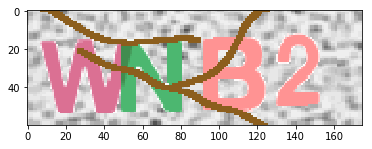

Image number: 68


In [4]:
(fname,img) = load_random_img(68)
print(break_captcha(img))
show(img)
print("Image number:", fname)

### Разбор алгоритма

Буквы имеют однотонный цвет и выделяются на фоне.

Для отделения букв, фона и цветных полос используем кластеризацию.

Функция `clusterize` выполняет кластеризацию на 8 кластеров по цвету, используя алгоритм `KMeans`.

`simple_bin` приводит изображения к бинарным, так как после кластеризации в изображениях хранится информация о цвете, которая болше не понадобится

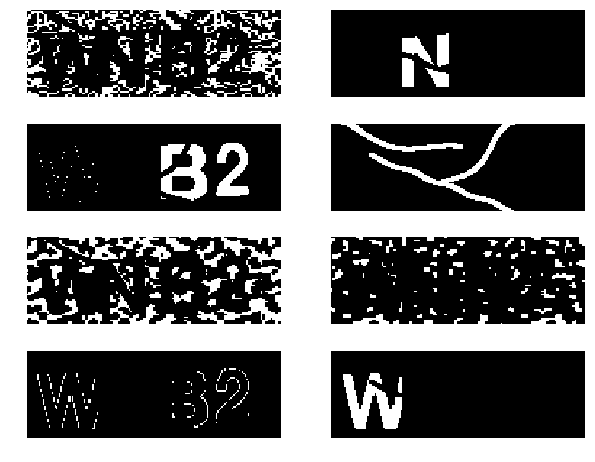

In [7]:
def show_clusters(clusters, labels = None):
    fig = plt.figure(figsize = (10,8))

    for (i, c) in enumerate(clusters, 1):
        a = fig.add_subplot(4,2,i)
        if labels is not None:
            a.set_title(labels[i-1])
        plt.axis('off')
        plt.imshow(c,cmap='gray',interpolation='none')
        
        
clusters = list(map(simple_bin, clusterize(img)))
show_clusters(clusters)


Таким образом, мы получили набор изображений, на некоторых из которых содержатся нужные символы, на остальных -- остатки фона и полосы.

Следующим этапом стал выбор характеристих, которые позволили бы из восьми полученных бинарных изображений выбрать те, на которых содержаться символы.

Предварительно к изображениям применялась эрозия и дилатация, чтобы убрать отдельные ненужные пиксели, попавшие в кластер, и залить разрывы на буквах, оставленные полосами.

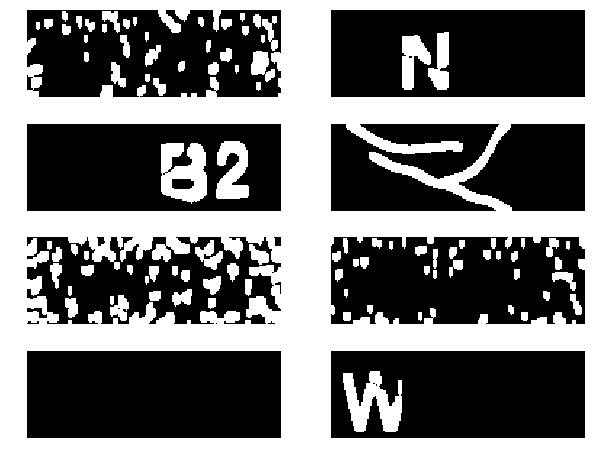

In [8]:
def morph(img):
    c_erode = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
    c_erode = cv2.morphologyEx(c_erode, cv2.MORPH_DILATE,
                               cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 6)))
    return c_erode

morph_clusters = list(map(morph, clusters))
show_clusters(morph_clusters)

Далее убираем изображения с большим количесвом связных комонент, так как символ обычно состоит из 2-3 компонент *(разрывы происходят лишь там, где сверху прошла зашумляющая полоса)*.

Ниже приведены изображения и число компонент связности на них:

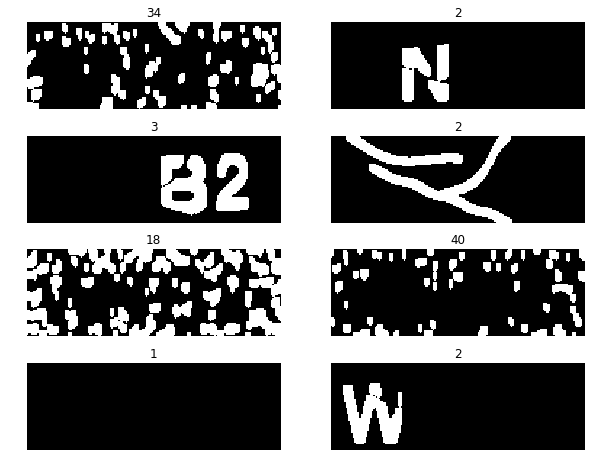

In [9]:
number_connected_components = lambda img: cv2.connectedComponentsWithStats(morph(img))[0]
show_clusters(morph_clusters, list(map(number_connected_components, morph_clusters)))

Оставляем только изображения с числом компонент `1 < c < 10`

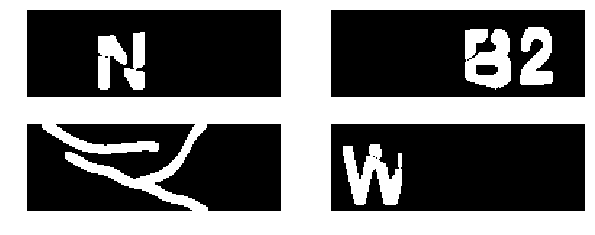

In [10]:
stage1_clusters = list(filter(filter_comp_count,morph_clusters))
show_clusters(stage1_clusters)

Далее рассмотрим каждый столбец изображения и посчитаем количесвто ненулевых точек в нем.
Таким образом мы получим связность вдоль оси y. 

Видно, что буквы имеют определенную ширину в пределах от 10 до 50 пикселей.
Поэтому выбираем только те изображения, где все интервалы подряд идущих ненулевых столбцов имеют заданную ширину.

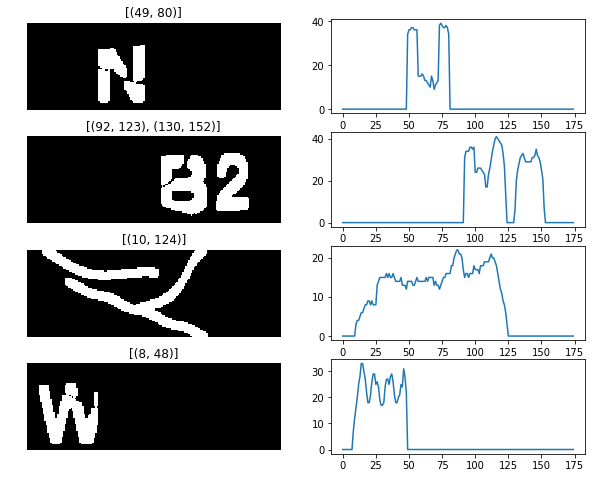

In [11]:
fig = plt.figure(figsize = (10,8))
i=1
for c in stage1_clusters:
    a = fig.add_subplot(4,2,i)
    a.set_title(find_cont_subsec(get_hist(c)))
    plt.axis('off')
    plt.imshow(c,cmap='gray')
    a = fig.add_subplot(4,2,i+1)    
    plt.plot(get_hist(c))
    i+=2
plt.show()

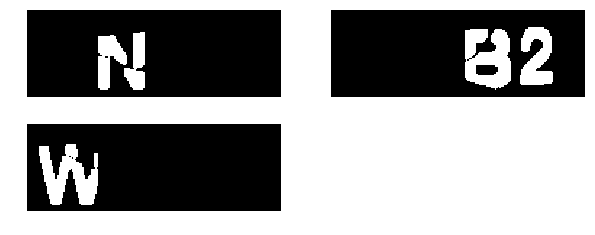

In [12]:
stage2_clusters =  list(filter(non_zero_seq, stage1_clusters))
show_clusters(stage2_clusters)

Теперь изображения готовы для распознавания. Используем программу для оптического разпознавания текста `Tesseract`

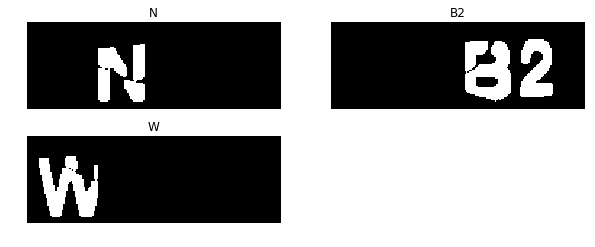

In [13]:
import pytesseract
from PIL import Image

def recog(img):
    pilimg = Image.fromarray(img)
    conf = '-psm 8 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890'
    res = pytesseract.image_to_string(pilimg, config=conf)
    return res

show_clusters(stage2_clusters, list(map(recog, stage2_clusters)))

Остлось лишь собрать буквы в правльном порядке на основе расстояния до левого края изображения.

Посмотрим примеры удачных и неудачных попыток распознавания:

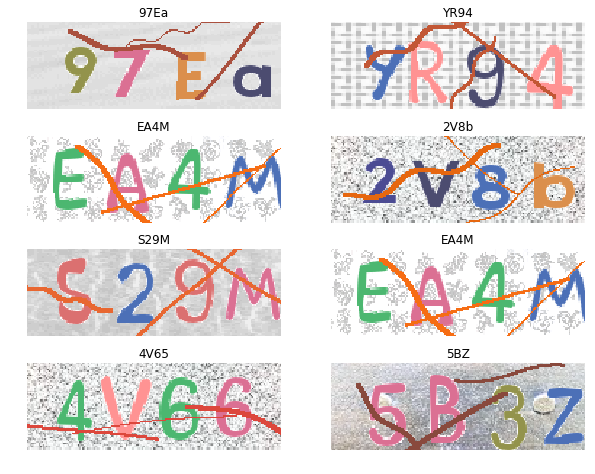

In [157]:
fig = plt.figure(figsize = (10,8))
for i in range(1,9):    
    (_,img) = load_random_img()    
    a = fig.add_subplot(4,2,i)
    a.set_title(break_captcha(img))
    plt.axis('off')
    plt.imshow(img,cmap='brg',interpolation='none')

Итоговая точность данного алгоритма составила 50-60%.

Ошибки происходят как на этапе кластеризации и отбора "хороших" кластеров, так и на этапе распознавания.

Долю ошибок на этапе предобработки можно уменьшить используя более точные критерии отбора кластеров, содержащих символы, или написав специализированный алгоритм кластеризацаии(что, однако, может повлиять на общность и не дать лучшего результата).

Система распознавания дает неверный результат либо в случае сильной изрезанности буквы перекрывающими полосами, либо из-за особенностей шрифта.